In [1]:
from matplotlib import pyplot as plt
from src.utils.config import load_config
import pickle
from src.data.dataset import Dataset, decode
from src.model.transformer import Transformer
from src.training.evaluator import Evaluator
from src.utils.transformer_analysis import *
from src.data.dyck_generator import generate_dyck_data
import torch
import torch.nn as nn
import sys
import os
import numpy as np
import random

# Set random seeds.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For CUDA reproducibility
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Example analysis

## 1. Load the model and dataset

In [ ]:
#=================================
# load your model here by specifying the training timestamp 
#---------------------------------
sesh = 'n13_head1'   # change this to your session name
                     # preloaded ones: n13_head1, n13_head2, n13_head3, n13_head4
                     
#=================================
# load config
config_path = f'cache/{sesh}/config'
config = load_config(config_path)

# load cached dataset, generate if not exists
batch_size = config['training']['batch_size']
n = config['data']['n']      
data_path = config['data']['data_path']
try:
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded successfully from {data_path}.")
except FileNotFoundError:
    print(f"Data file not found.")
    generate_dyck_data(n, data_path)
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Data generated and loaded successfully.")
except Exception as e:
    raise Exception(f"Error loading saved data: {e}.")
dataset = Dataset(data,seed=seed,batch_size=batch_size)

# load the best trained model from the designated session
model_args = config['model']
model_args['max_len'] = n*2 + 1  # +1 for BOS token
max_new_tokens = model_args['max_len'] - 1  # Exclude BOS token, so -1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()      
model = Transformer(**model_args)
model_path = f'cache/{sesh}/best_model.pth'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.to(device)
model.eval()
print(f"Best model loaded from {sesh}.")

# Evaluate the model on the validation dataset to see how it performs
evaluator = Evaluator(model, dataset.eval_dataloader, criterion, device)
eval_loss_epoch, eval_accuracy_epoch = evaluator.evaluate(max_new_tokens)
print(f"validation data: loss = {eval_loss_epoch:.4f}, accuracy = {eval_accuracy_epoch:.8f}")

# load analysis examples from the validation dataset
examples = {
    'inputs': dataset.eval_dataloader.dataset.tensors[0].to(device),  # First 5 inputs
    'targets': dataset.eval_dataloader.dataset.tensors[1].to(device)   # First 5 targets
}

Data loaded successfully from data/dyck_data_13.pkl.
Best model loaded from n13_head1.
validation data: loss = 0.0001, accuracy = 0.99780000


## 2. Example Usage

### Example 2a. Visualize encoder, decoder self-attention, cross-attention, and Dyck Paths for one example

Input: bos 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0
Target: bos 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0


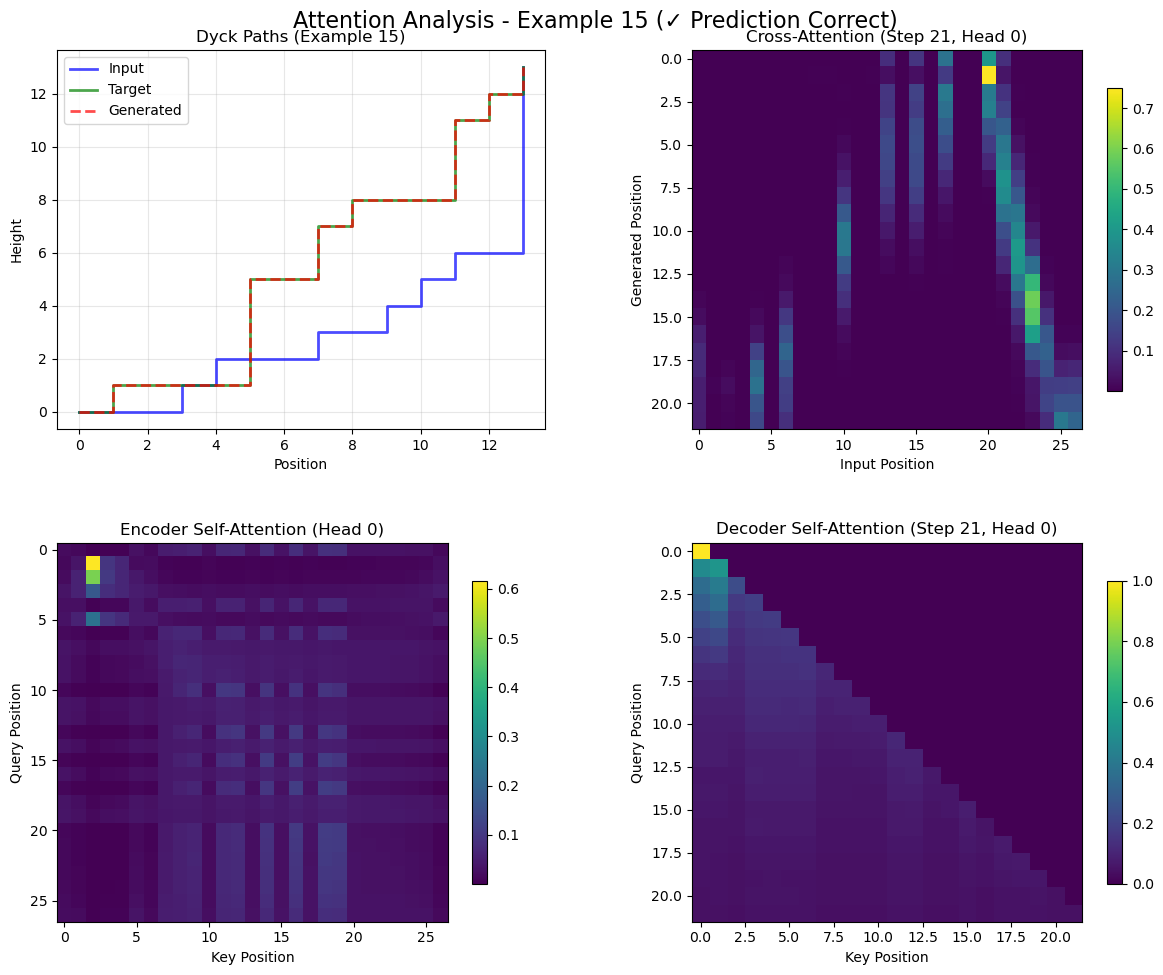

In [9]:
# Example: Analyze data example #15
# this if for all attention heads numbered 0 at step 21 (the 22th token generated in the sequence)
#=================
ex_idx = 15  # the index of the first example to analyze
encoder_att_head = 0  # which encoder self-attention head to analyze
decoder_att_head = 0  # which decoder self-attention head to analyze
cross_att_head = 0  # which cross-attention head to analyze
step = 21  # which token is being generated in the sequence when analyzing cross-attention
# some plotting parameters
figsize = (12,10)  # figure size for visualization
cmap = 'viridis'  # colormap for visualization, e.g. 'Blues', 'inferno', 'viridis'
#=================
# outputs = analyze_cross_attention(model, examples, start_idx=start_idx, step=step, att_head=att_head, num_examples=num_examples)
print(f"Input: {decode(examples['inputs'][ex_idx], dataset.dictionary)}")
print(f"Target: {decode(examples['targets'][ex_idx], dataset.dictionary)}")
outputs = attention_example(model, examples, ex_idx=ex_idx, step=step, encoder_att_head=encoder_att_head, decoder_att_head=decoder_att_head, cross_att_head=cross_att_head, figsize=figsize, cmap=cmap)

### Example 2b. Visualize Cross Attentions for a Batch of Examples

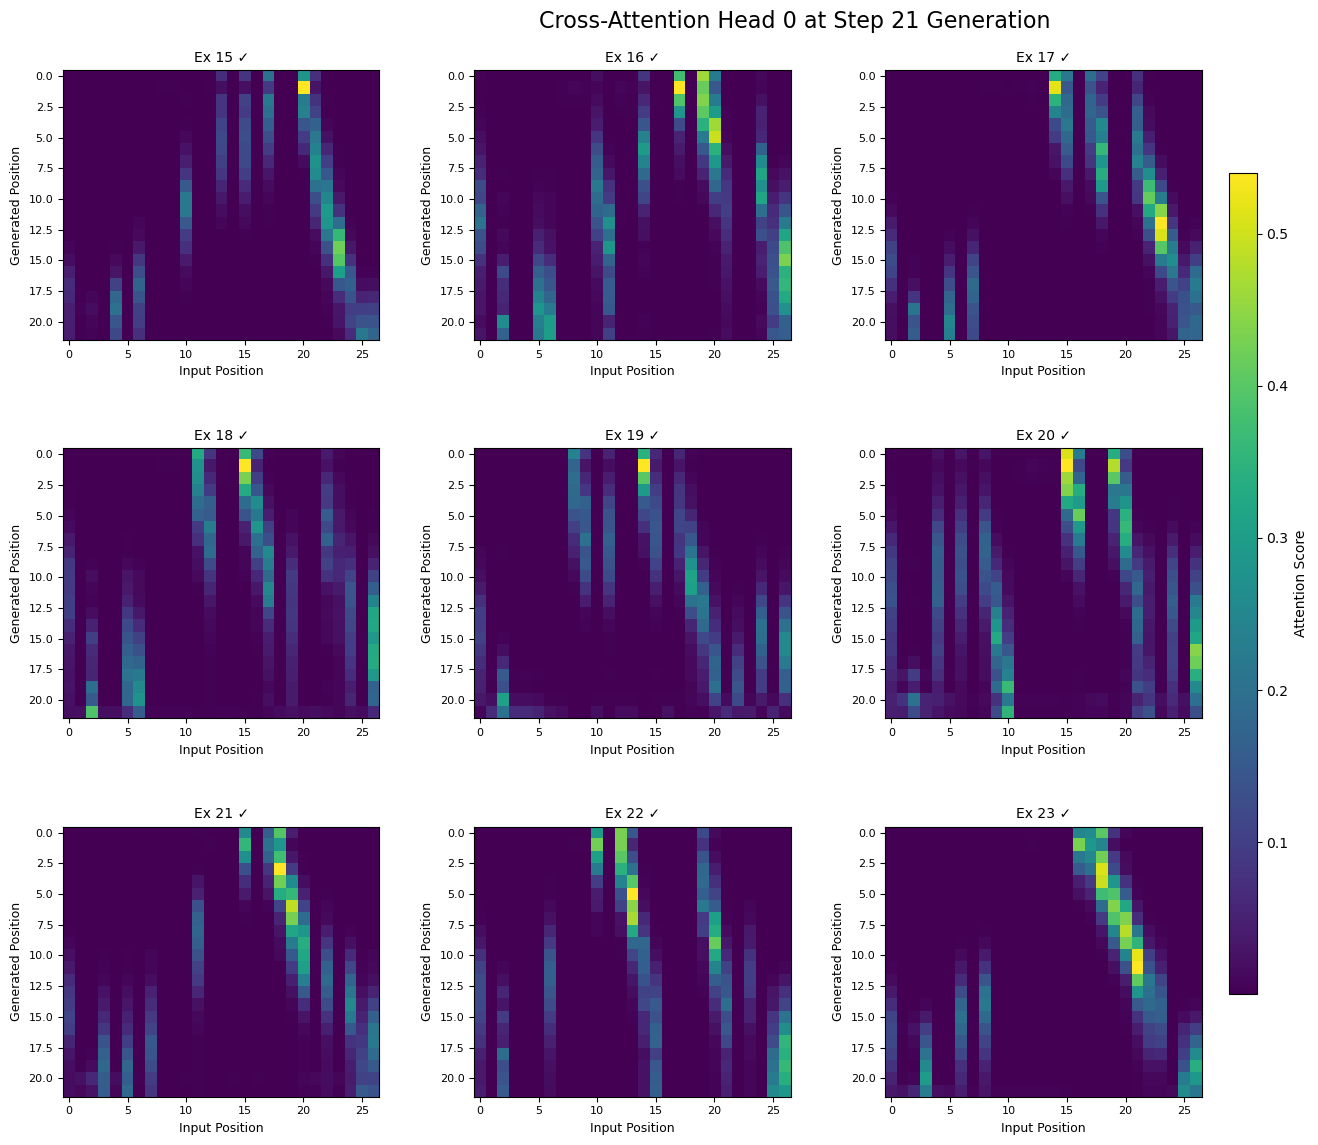

In [4]:
# Example: Analyze 9 examples starting from example #15
# this if for attention head 0 at step 21 (the 22th token generated in the sequence)
# The ✓ and ✗ in the title indicate whether the Dyck path is predicted correctly or not
#=================
start_idx = 15  # the index of the first example to analyze
num_examples = 9  # Number of examples to show
att_head = 0    # attention head to visualize
step = 21  # which token is being generated in the sequence when analyzing cross-attention
# some plotting parameters
figsize = (16, 12)  # figure size for visualization
cmap = 'viridis'  # colormap for visualization, e.g. 'Blues', 'inferno', 'viridis'
#=================
outputs = analyze_cross_attention(model, examples, start_idx=start_idx, step=step, att_head=att_head, num_examples=num_examples, figsize=figsize, cmap=cmap)

### Example 2c. Visualize encoder self attention for a batch of examples

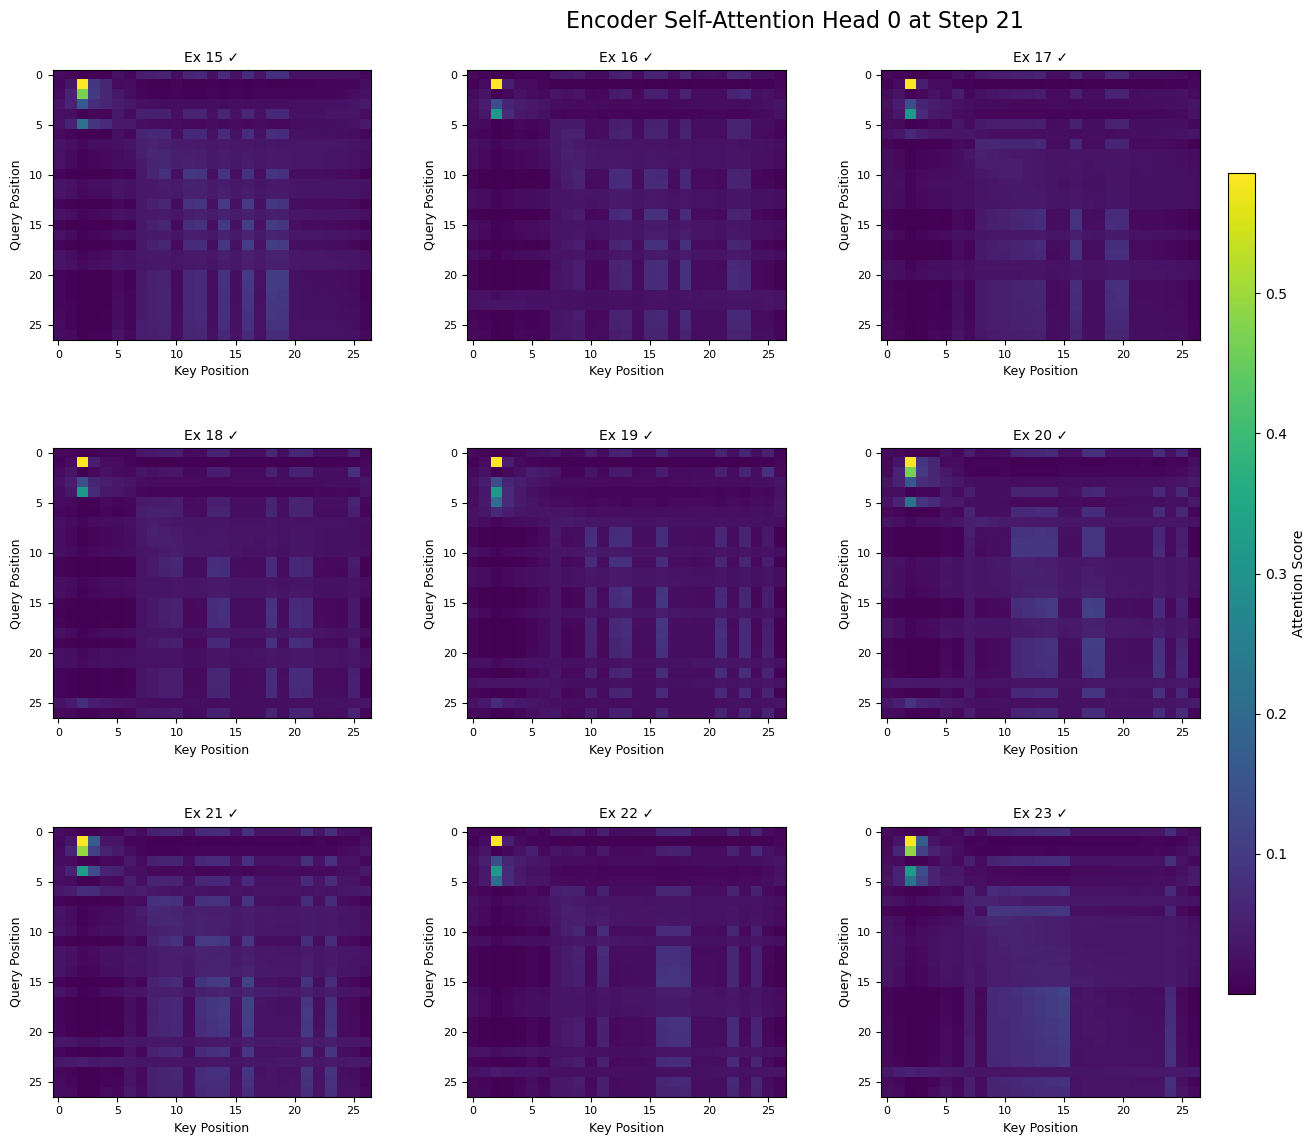

In [5]:
# Example: Analyze 9 examples starting from example #15
# this if for attention head 0 at step 21 (the 22th token generated in the sequence)
# The ✓ and ✗ in the title indicate whether the Dyck path is predicted correctly or not
#=================
start_idx = 15  # the index of the first example to analyze
num_examples = 9  # Number of examples to show
att_head = 0    # attention head to visualize
step = 21  # which token is being generated in the sequence when analyzing attention
# some plotting parameters
figsize = (16, 12)  # figure size for visualization
cmap = 'viridis'  # colormap for visualization, e.g. 'Blues', 'inferno', 'viridis'
#=================
outputs = analyze_encoder_attention(model, examples, start_idx=start_idx, step=step, att_head=att_head, num_examples=num_examples, figsize=figsize, cmap=cmap)

### Example 2d. Visualize decoder self attention for a batch of examples

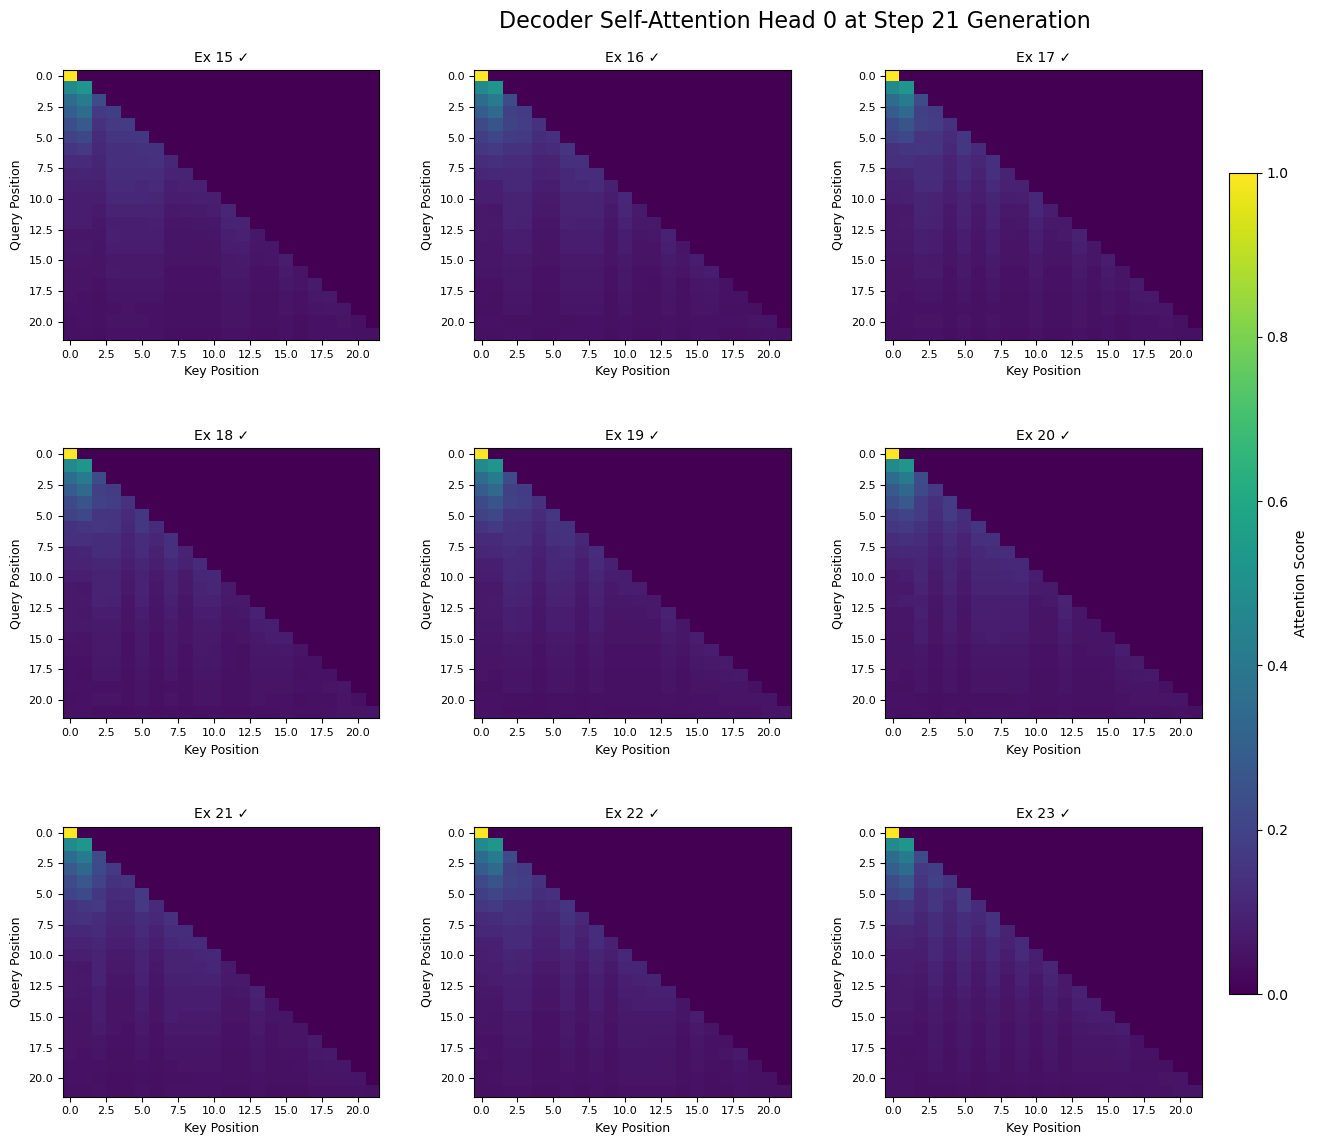

In [6]:
# Example: Analyze 9 examples starting from example #15
# this if for attention head 0 at step 21 (the 22th token generated in the sequence)
# The ✓ and ✗ in the title indicate whether the Dyck path is predicted correctly or not
#=================
start_idx = 15  # the index of the first example to analyze
num_examples = 9  # Number of examples to show
att_head = 0    # attention head to visualize
step = 21  # which token is being generated in the sequence when analyzing attention
# some plotting parameters
figsize = (16, 12)  # figure size for visualization
cmap = 'viridis'  # colormap for visualization, e.g. 'Blues', 'inferno', 'viridis'
#=================
outputs = analyze_decoder_attention(model, examples, start_idx=start_idx, step=step, att_head=att_head, num_examples=num_examples, figsize=figsize, cmap=cmap)

### Example 2e. Visualize cross attention across all the steps

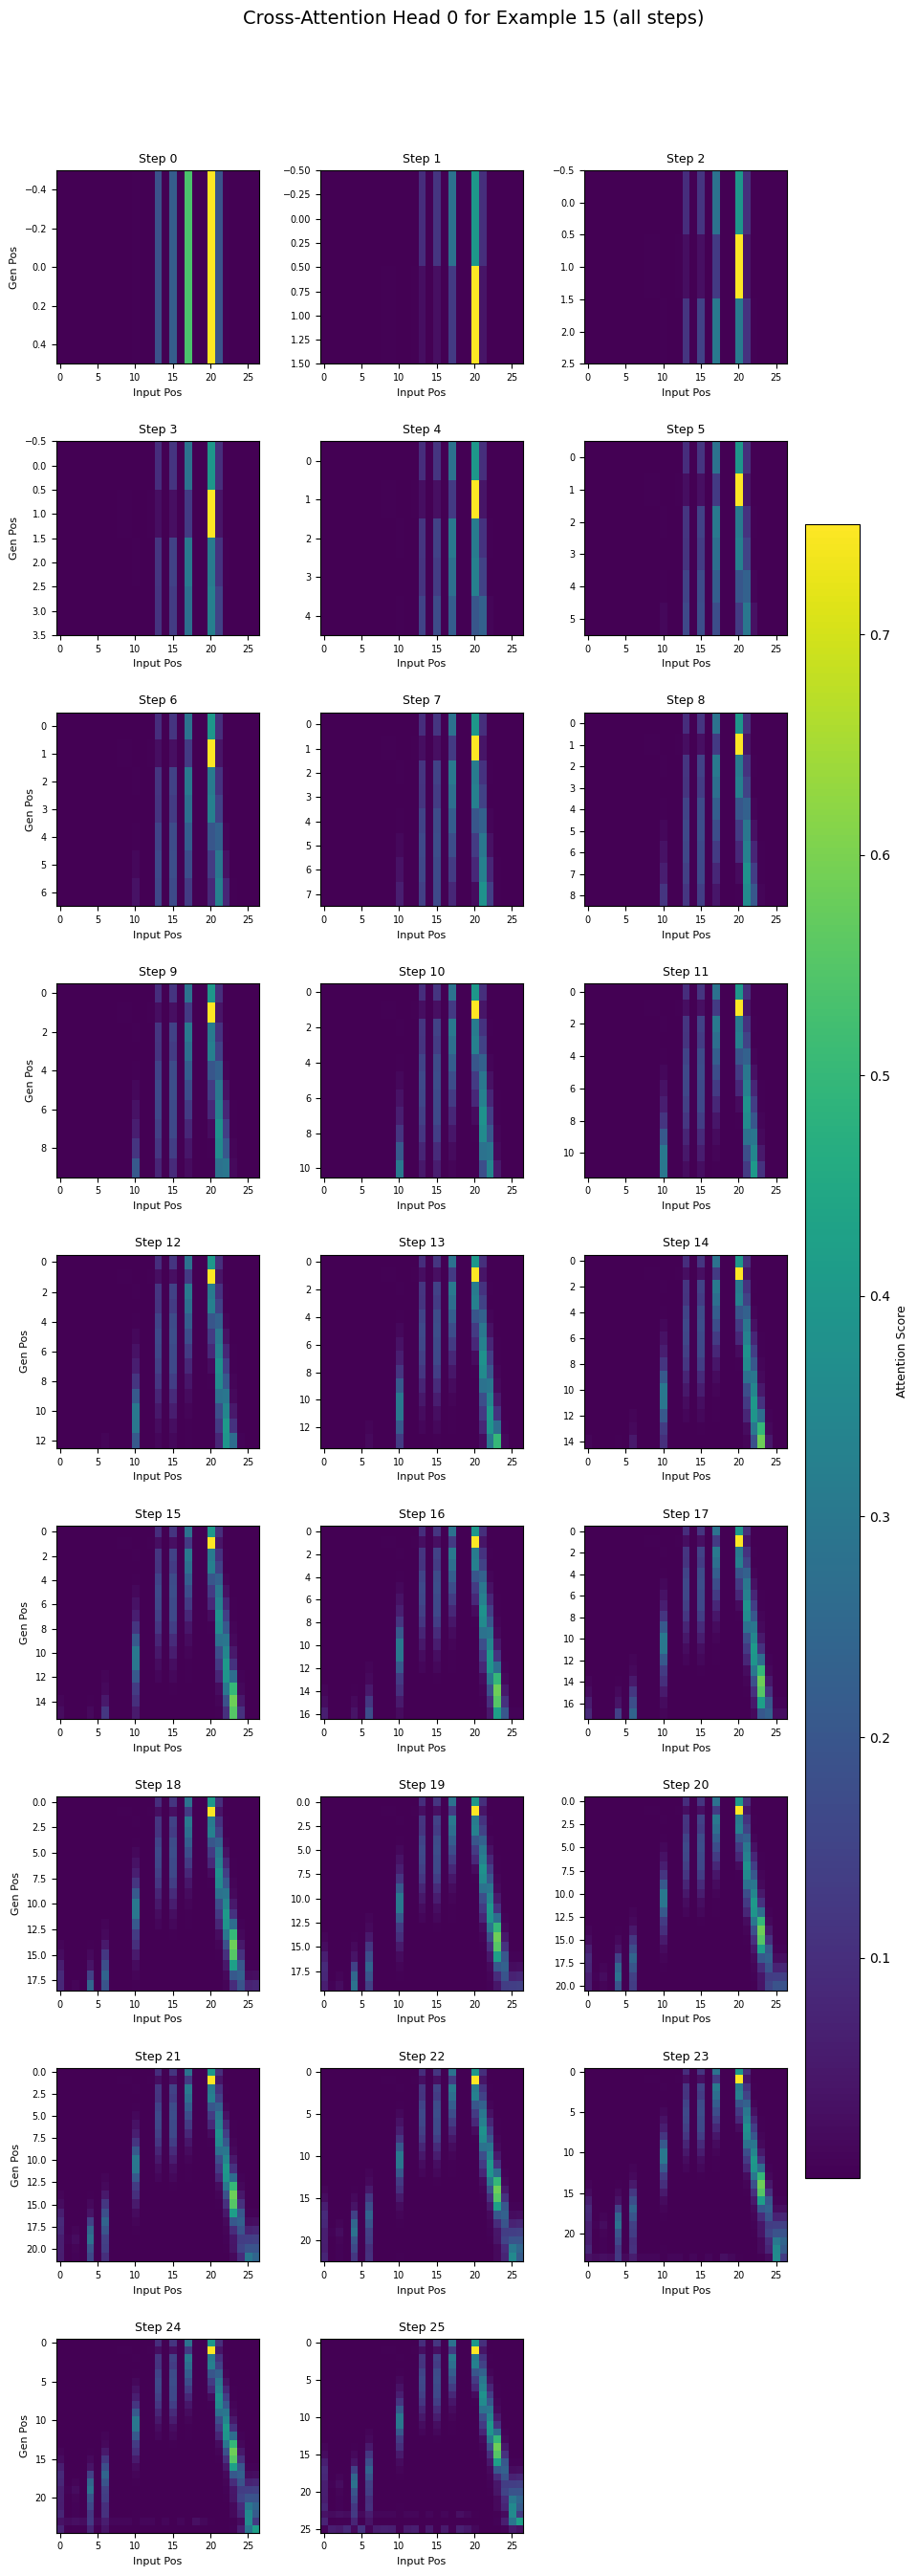

In [7]:
# Example: Analyze example #15
# this if for attention head 0 at step 21 (the 22th token generated in the sequence)
#=================
ex_idx = 15  # the index of the first example to analyze
att_head = 0    # attention head to visualize
# some plotting parameters
figsize = (10,28)  # figure size for visualization
cmap = 'viridis'  # colormap for visualization, e.g. 'Blues', 'inferno', 'viridis'
#=================
outputs = analyze_cross_attention_all_steps(model, examples, ex_idx=ex_idx, att_head=att_head, figsize=figsize, cmap=cmap)

### Example 2f. PCA of encoder and decoder embeddings

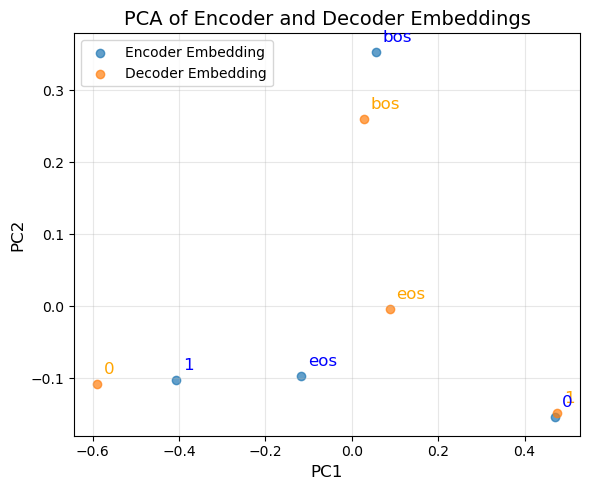

In [8]:
# run a PCA on the encoder and decoder embeddings
outputs = analyze_embeddings_pca(model, dataset, figsize=(6, 5), alpha=0.7, fontsize=12)